In [1]:
import numpy as np
import pandas as pd
import librosa

import os
import time
import re
from tqdm import tqdm
import h5py

import tensorflow as tf
from tensorflow.keras.utils import to_categorical, plot_model

import matplotlib.pyplot as plt
import IPython.display
import librosa.display

# Use GPU
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3207456133572094563
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 11886538117858876486
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7046801664
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13055631940220882583
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 10051833904147171999
physical_device_desc: "device: XLA_GPU device"
]


## Loading Functions

In [2]:
# Load saved data
def Load_Augmented(name='', path='Augmented_Data/'):
    '''
        Input:
            name:      name of the file
            path:      path of the file
        
        Output:
            dataset:   loaded dataset with data and labels
    '''
    hf = h5py.File(path + name + '.h5', 'r')
    data =  np.array(hf.get('data'))
    labels = np.array(hf.get('label'))
    hf.close()
    
    data = np.asarray(data, dtype=np.float32)
    label = np.asarray(labels, dtype=np.float32)
    '''
    dataset = []
    for i in range(len(data)):
        dataset.append([data[i], labels[i]])
    
    dataset = np.asarray(dataset, dtype=object)
    '''
    return data, labels


def Preprocessing(raw_audio, labels, bands=60, frames=41):
    '''
        Input:
            raw_audio:     list that contains the raw/augmented data
            labels:        list that contains the category information
            bands:         number of mel band to use
            frames:        number of frames to use
        
        Output:
            features:      numpy array that contains processed audio data with log-melspec and delta
            new_labels:    new labels for each augmented segment
    '''    
    
    new_labels = []
    augmented_spec = []
    
    # Normalize the raw data
    norm_factor = np.percentile(raw_audio, 99) - np.percentile(raw_audio, 5)
    raw_audio = raw_audio / norm_factor
    
    # Loop over each file audio
    for num, audio in enumerate(tqdm(raw_audio)):
    
        # Convert audio to melspectogram
        '''
            With default n_fft=2048 we have the filter size of 2048/2+1=1025 [Nyquist Frequency]
        '''
        melspec = librosa.feature.melspectrogram(audio, n_mels=bands, hop_length=512)
        
        # Convert melspec to log melspec
        logspec = librosa.core.amplitude_to_db(melspec)
        
        counter = 0
        # Spectrogram splitting with 50% overlap and adapt cv-fold and labels info
        for idx in range(0, len(logspec[0]) - frames, int(frames/2)):
            augmented_spec.append(logspec[:, idx:idx+frames])
            new_labels.append(labels[num])
            counter = counter +1
            
    # Reshape the outputs
    log_specgrams = np.asarray(augmented_spec).reshape(len(augmented_spec), bands, frames, 1)
    features = np.concatenate((log_specgrams, np.zeros(np.shape(log_specgrams))), axis=3)
    new_labels = np.asarray(new_labels)
    
    # Fill the delta features
    for i in range(len(log_specgrams)):
        features[i, :, :, 1] = librosa.feature.delta(features[i, :, :, 0])
    
    features = features.astype(np.float64)
    labels = labels.astype(np.float32)
    return features, new_labels



def CreateTrainingSet(f1, f2, f3, lf1, lf2, lf3, batch_size=32):
    
    # Create training set
    merged_training_data = np.concatenate((f1, f2, f3))
    merged_training_label = np.concatenate((lf1, lf2, lf3))

    # Create and cache training
    training_dataset = tf.data.Dataset.from_tensor_slices((merged_training_data, merged_training_label))
    training_dataset = training_dataset.batch(batch_size=batch_size)
    training_dataset = training_dataset.cache("training_cache")
    training_dataset = training_dataset.prefetch(buffer_size=1)
    
    return training_dataset



def CreateValidationSet(f1, lf1, batch_size=32):

    # Create and cache training
    validation_dataset = tf.data.Dataset.from_tensor_slices((f1, lf1))
    validation_dataset = validation_dataset.cache("validation_cache")
    validation_dataset = validation_dataset.batch(batch_size=batch_size)
    validation_dataset = validation_dataset.prefetch(buffer_size=1)
    
    return validation_dataset

## Model Functions

In [3]:
def PiczakNet(input_shape):
    
    X_input = tf.keras.Input(input_shape)
    
    # First convolution block
    model = tf.keras.layers.Conv2D(80, kernel_size=(57, 6), strides=1, padding='same', name='conv0')(X_input)
    model = tf.keras.layers.Activation('relu')(model)
    model = tf.keras.layers.MaxPool2D(pool_size=(4, 3), strides=(1, 3), padding='same')(model)
    model = tf.keras.layers.Dropout(0.5)(model)
    
    # Second convolution block
    model = tf.keras.layers.Conv2D(80, kernel_size=(1, 3), strides=1, padding='same', name='conv1')(model)
    model = tf.keras.layers.Activation('relu')(model)
    model = tf.keras.layers.MaxPool2D(pool_size=(1, 3), strides=(1, 3), padding='same')(model)
    
    # Flatten
    model = tf.keras.layers.Flatten()(model)
    
    # First fully-connected block
    model = tf.keras.layers.Dense(5000, activation='relu', name='fc0')(model)
    model = tf.keras.layers.Dropout(0.5)(model)
    
    # Second fully-connected block
    model = tf.keras.layers.Dense(5000, activation='relu', name='fc1')(model)
    model = tf.keras.layers.Dropout(0.5)(model)
    
    # Output layer
    model = tf.keras.layers.Dense(50, activation='softmax', name='out')(model)
    
    # Create model
    model = tf.keras.Model(inputs = X_input, outputs = model, name='PiczakNet')
    
    return model

## Define the Network

Model: "PiczakNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 60, 41, 2)]       0         
_________________________________________________________________
conv0 (Conv2D)               (None, 60, 41, 80)        54800     
_________________________________________________________________
activation (Activation)      (None, 60, 41, 80)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 14, 80)        0         
_________________________________________________________________
dropout (Dropout)            (None, 60, 14, 80)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 60, 14, 80)        19280     
_________________________________________________________________
activation_1 (Activation)    (None, 60, 14, 80)        0 

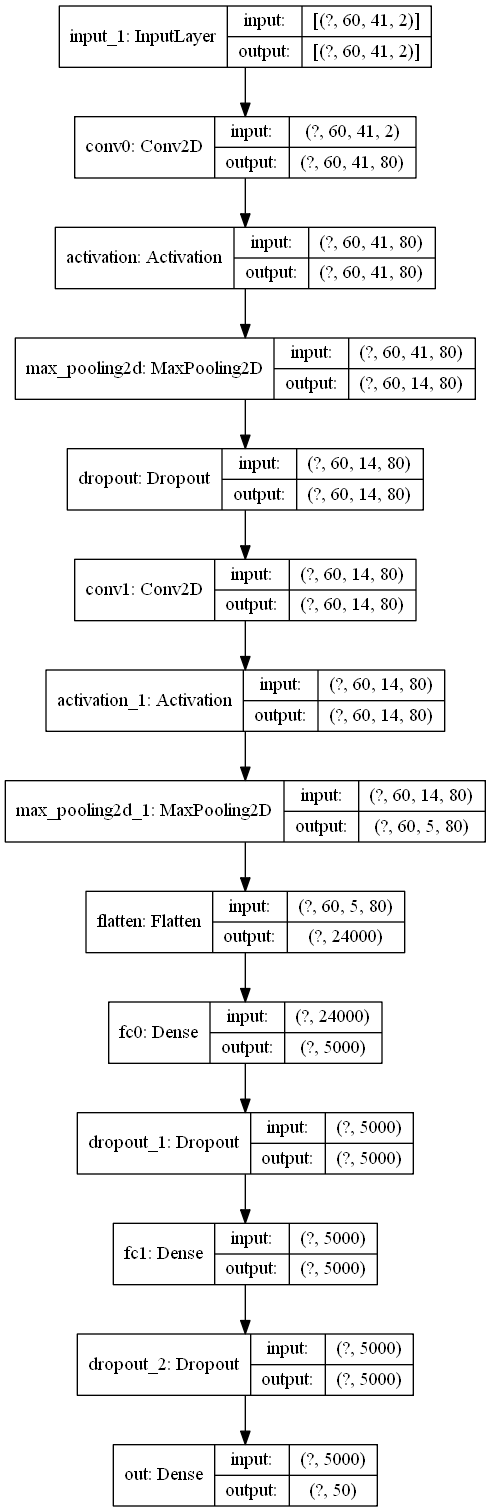

In [4]:
PiczakNet = PiczakNet([60, 41, 2])

print(PiczakNet.summary())

plot_model(PiczakNet, show_shapes=True, show_layer_names=True)

## Load Data

In [5]:
# Load
af1, alf1 = Load_Augmented(name='af1', path='Augmented_2/')
af2, alf2 = Load_Augmented(name='af2', path='Augmented_2/')
af4, alf4 = Load_Augmented(name='af4', path='Augmented_2/')
af5, alf5 = Load_Augmented(name='af5', path='Augmented_2/')

# Compute the features
f1_processed, lf1_processed = Preprocessing(af1, alf1)
f2_processed, lf2_processed = Preprocessing(af2, alf2)
f4_processed, lf4_processed = Preprocessing(af4, alf4)
f5_processed, lf5_processed = Preprocessing(af5, alf5)

OSError: Unable to open file (unable to open file: name = 'Augmented_2/af1.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
# Generate training and validation set

training_dataset = CreateTrainingSet(f1_processed, f2_processed, f4_processed, lf1_processed, lf2_processed, lf4_processed)

validation_dataset = CreateValidationSet(f5_processed, lf5_processed)

In [ ]:
opt = tf.keras.optimizers.Adam(lr=0.0002)
PiczakNet.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
max_epochs = 50

epoch_loss= []
epoch_acc = []

epoch_vl = []
epoch_va = []

# Loop over the epochs
for epoch in range(max_epochs):
    
    # Shuffle the training
    training_dataset = training_dataset.shuffle(len(af1)*3)
    
    step_loss = []
    step_acc = []
    
    step_vl = []
    step_va = []
    
    start = time.time()
    # train over mini-batches
    for x_batch, y_batch in training_dataset:
        
        # train on batch
        step_stats = PiczakNet.train_on_batch(x_batch, y_batch)
        
        # save loss and accuracy
        step_loss.append(step_stats[0])
        step_acc.append(step_stats[1])
        
    # compute validation stats
    for x_batch, y_batch in validation_dataset:
        
        # compute validation stats
        val_stats = PiczakNet.test_on_batch(x_batch, y_batch)
        
        # save loss and accuracy
        step_vl.append(val_stats[0])
        step_va.append(val_stats[1])
    end = time.time()
        
    # Save the mean loss and accuracy of the entire epoch
    epoch_loss.append(np.mean(step_loss))
    epoch_acc.append(np.mean(step_acc))
    epoch_vl.append(np.mean(step_vl))
    epoch_va.append(np.mean(step_va))
    
    # Print epoch training stats
    print("Epoch %2d: \t t-loss: %3.6f \t t-acc: %.6f \t v-loss: %3.6f \t v-acc: %.6f \t time: %3.3f" % (epoch + 1, epoch_loss[-1], epoch_acc[-1], epoch_vl[-1], epoch_va[-1], (end - start)))

In [ ]:
plt.figure()
plt.plot(epoch_loss, label='training loss')
plt.plot(epoch_vl, label='validation loss')
plt.legend()
plt.show()
plt.close('all')

In [ ]:
plt.figure()
plt.plot(epoch_acc, label='training acc')
plt.plot(epoch_va, label='validation acc')
plt.legend()
plt.show()
plt.close('all')